In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.lines import Line2D
from scipy.stats import beta as beta_dist
import pandas as pd
from tabulate import tabulate
import warnings
import seaborn as sns
import cvxpy as cp
import pdb
import os.path as osp
import pytest

In [2]:
%load_ext autoreload
%autoreload 2
from rankingFairness.src.experiment import BayesianSetup
from rankingFairness.src.utils import set_seed
from rankingFairness.src.rankings import PRP_Ranker, EO_RankerII, DP_Ranker, EO_Ranker
from rankingFairness.src.distributions import BernGreedy, BernThompson,Bernoulli
from rankingFairness.src.tradeoff import UtilityCost

In [3]:
SEED=42
set_seed(SEED)

In [4]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
import matplotlib
matplotlib.style.use('classic')

/tmp/ipykernel_1641943/1290025429.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [5]:
def initVals(A_true, B_true):
    n_A=sum(A_true)
    n_B=sum(B_true)
    n_group=[n_A, n_B]
    probs_all = np.concatenate((A_true, B_true))
    start_minority_idx = len(A_true)
    ids = np.arange(len(A_true)+len(B_true))
    delta_max = ((np.sort(A_true, axis=0)[-1]/n_group[0]) + (np.sort(B_true, axis=0)[-1]/n_group[1]))/2
    return n_A, n_B, probs_all, start_minority_idx, ids, delta_max

In [6]:
def getUtilMax(probs_all, n_A, n_B, delta_max, k, A_true, B_true, start_minority_idx):
    X = cp.Variable(ids.shape)
    objective = cp.Maximize((probs_all@X/(n_A+n_B)))
    constraints = []
    constraints += [cp.sum(X)==k]
    constraints += [X>=0]
    constraints += [X<=1]
    constraints += [(A_true@X[:start_minority_idx]/n_A) - (B_true@X[start_minority_idx:]/n_B) <= delta_max]
    constraints += [(A_true@X[:start_minority_idx]/n_A) - (B_true@X[start_minority_idx:]/n_B) >= -delta_max]
    prob = cp.Problem(objective, constraints)
    results=prob.solve(verbose=False)
    return X, results

In [7]:
def getUtilMaxILP(probs_all, n_A, n_B, delta_k, k, A_true, B_true, start_minority_idx):
    X = cp.Variable(ids.shape, integer=True)
    objective = cp.Maximize((probs_all@X/(n_A+n_B)))
    constraints = []
    constraints += [cp.sum(X)==k]
    constraints += [X>=0]
    constraints += [X<=1]
    constraints += [cp.norm(((A_true@X[:start_minority_idx]/n_A) - (B_true@X[start_minority_idx:]/n_B)),1) <= delta_k]
    prob = cp.Problem(objective, constraints)
    results=prob.solve(verbose=False)
    return X, results

In [8]:
def computeBound(pa, pb, n_A, n_B, delta_max, delta_k):
    bound=(2*abs(delta_k)*abs(pa-pb))/(((pa/n_A)+(pb/n_B))*(n_A+n_B))
    return bound

n_A:4.00, n_B:4.00, delta_max:0.250
max diff:0.06136363636363627, 1/(n_A+n_B):0.12499999999999994


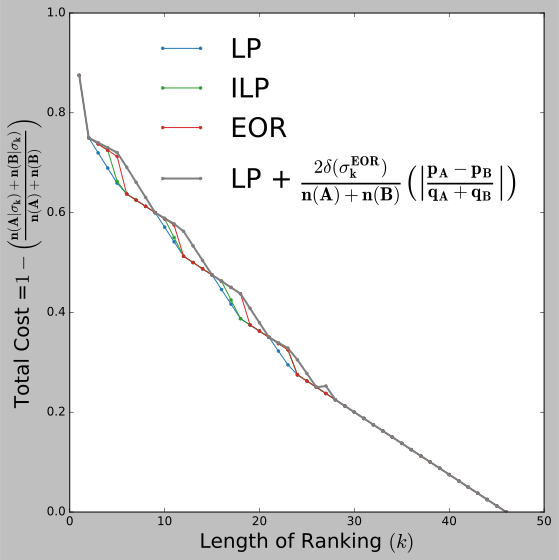

In [9]:

fig = plt.figure(figsize=(8,8))
util_max, util_min, util_EOR, bound_ls, util_maxILP =[],[],[],[],[]
colorMap=['tab:blue', 'tab:green', 'tab:grey', 'tab:red', 'tab:brown']
rel_diff=1
epsilon=1e-11


A_true = np.array([1, 0.6, 0.5, 0.5, 0.4, 0.1, 0.1, 0.1,0.1,0.1, 0.1,0.1,0.1,0.1,0.1])
B_true = np.array([1]+[0.1]*30)

n_A, n_B, probs_all, start_minority_idx, ids, delta_max=initVals(A_true, B_true)
print(f"n_A:{n_A:.2f}, n_B:{n_B:.2f}, delta_max:{delta_max:.3f}")
merit_dist_A = [Bernoulli(p) for p in A_true]
merit_dist_B = [Bernoulli(p) for p in B_true]
for k in range(1,len(ids)+1):
    EOR = EO_RankerII([merit_dist_A, merit_dist_B])
    EOR.rank(k)

    util_EOR.append(probs_all[EOR.ranking].sum()/(n_A+n_B))
    
    delta_k=EOR.getEOR(EOR.ranking)[1]
    assert math.isclose(delta_k, delta_max) or delta_k<delta_max , f"k:{k}, delta_k:{delta_k}"
    
    pa=EOR.arm_a
    pb=EOR.arm_b   
    bound_ls.append(computeBound(pa, pb, n_A, n_B, delta_max, delta_k))
    
    X_sol, results = getUtilMaxILP(probs_all, n_A, n_B, abs(delta_k), k, A_true, B_true, start_minority_idx)
    util_maxILP.append(results)
    X_sol, results = getUtilMax(probs_all, n_A, n_B, abs(delta_k), k, A_true, B_true, start_minority_idx)
    util_max.append(results)
    

    assert math.isclose(util_EOR[-1],(util_max[-1]-bound_ls[-1])) or util_EOR[-1]>(util_max[-1]-bound_ls[-1]),f"{k},{util_max[-1]-bound_ls[-1]},{util_EOR[-1]}"

print(f"max diff:{np.max(bound_ls)}, 1/(n_A+n_B):{1/(n_A+n_B)}")
assert math.isclose(np.max(bound_ls), 1/(n_A+n_B)) or np.max(bound_ls)<1/(n_A+n_B)
# plt.hlines(y=1, xmin=1, xmax=len(ids), color='black', linestyle='dashed')
plt.plot(np.arange(1, len(ids)+1), [1-j for j in util_max], marker='.', c=colorMap[0], label=r'LP')
plt.plot(np.arange(1,len(ids)+1), [1-j for j in util_maxILP], marker='.', c=colorMap[1], label=r'ILP')

plt.plot(np.arange(1,len(ids)+1), [1-j for j in util_EOR], marker='.', c=colorMap[3], label=r'EOR')
plt.plot(np.arange(1,len(ids)+1), [1-i+j for i,j in zip(util_max, bound_ls)], 
         marker='.', c=colorMap[2], 
label=r'LP + '+r'$\bf{\frac{2\delta(\sigma^{EOR}_k)}{n(A)+n(B)}\left(\left| \frac{p_A-p_B}{q_A+q_B} \right|\right)}$',
         linewidth=2)



plt.xlabel(r'Length of Ranking $(k)$', fontsize=20)
plt.ylabel(r'Total Cost =' + r'$\bf{1-\left(\frac{n(A|\sigma_k) + n(B|\sigma_k)}{n(A)+n(B)}\right)}$', fontsize=20)
plt.legend(fontsize=27, loc='upper right', frameon=False)
fig.tight_layout()
saveFig_path='/share/thorsten/rr568/CostOptimal_FairRankings/plots'
plt.savefig(f"{osp.join(saveFig_path,'Thm1.pdf')}", bbox_inches='tight')
plt.show()
plt.close()